<a href="https://colab.research.google.com/github/ash-rulz/RAG/blob/main/NLPTransQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answering(QA)


*   Extractive QA: Answers can be identified using span of text in a document
*   Community QA: Involves gathering QA pairs from user forums like Stack-Overflow
* Long-form QA: Generates complex paragraph-length answers


# Extracting Answers from Text

## Span classification task
Model needs to predict the start and end tokens of an answer span.

If the training set is small, use a [language model](https://huggingface.co/models?pipeline_tag=question-answering&search=squad).  that is fine-tuned on large-scale QA dataset like SQuAD.

## Tokenization text for QA
Use [minilm](https://huggingface.co/deepset/minilm-uncased-squad2) with 33.4M params for tokenization. [Paper](https://arxiv.org/abs/2002.10957)

In [1]:
from transformers import AutoTokenizer

#Load the model with the frozen parameters
model_ckpt = "deepset/minilm-uncased-squad2"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [2]:
#Sample question and context to tokenize
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt") #Returns as a pytorch tensor

In [3]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

token_type_ids: Which part is question and context?

attention_mask: Allows the model to focus on the relevant parts of the text, in this case both the question and context.

In [4]:
#Decode back the text using the input_ids
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [5]:
#Instantiate the model with QA head and do forward pass
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)#Use the same model minilm as we used in tokenizer

#We need to disable gradient tracking as this is inference and not training. Gradient tracking is a feature of PyTorch that is used for training models.
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


Further information for gradient tracking in pytorch can be obtained from [autograd](https://www.youtube.com/watch?v=DbeIqrwb_dE)

In [6]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")
#There are as many logits as there are inputs

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [7]:
#Get the answer from the logits
start_idx = torch.argmax(start_logits)#Gets the start span
end_idx = torch.argmax(end_logits) + 1#Gets the end span

#Gets the answer and decodes it
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


All this can be wrapped in a dedicated pipeline:

In [8]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k =3)

[{'score': 0.2651607394218445, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.2208300530910492,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253580659627914,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

This will give multiple answers for the same question with different scores. If the model is not able to find the right answer, the start and end wuld point to the [CLS] token

## Dealing with long passages

For tasks like text classification we could use [CLS], but for QA we would need to use *sliding window*. For the same question, slide the context bar across the window:
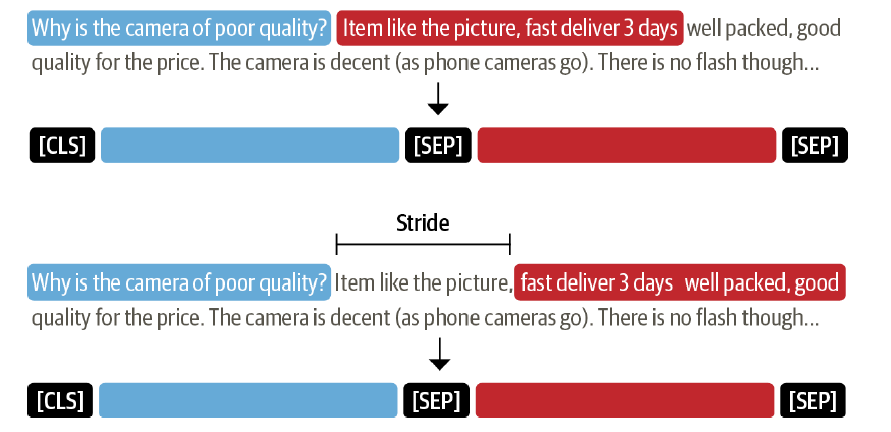

We use this technique in the tokenizer function.


```
#Enables the sliding window
return_overflowing_tokens=True
```

```
#Size of the sliding window
max_seq_length
```

```
#Size of the stride
doc_stride
```


The windows will overlap.

# Using Haystack to Build a QA Pipeline

QA systems are based on the **retriever-reader architecture**.

*Retriever*
Retrieves the relevant documents for the query. 2 types:
1.   *Sparse Retrievers*: Documents and query is represented by word frequencies, like TF-IDF & BM25.
2.   *Dense Retrievers*: Documents and query are converted to contexturalized embeddings using encoders, like Embedding and DPR(Dense Passage Retriever).

*Reader*
Extracts the answers from the documents. This is usually a *reading-comprehension model*.

Document post-procession like re-ranking retrieved documents and Answer post-processing like cherry-picking the answers from various passages from a long document.

In addition to a Retriever and Reader, a Document store and a pipeline is required. For document store, Elasticsearch is used and for the pipeline Haystack is used.


## Initializing a document store

Haystack's document store expects a list of dictionaries of the form:
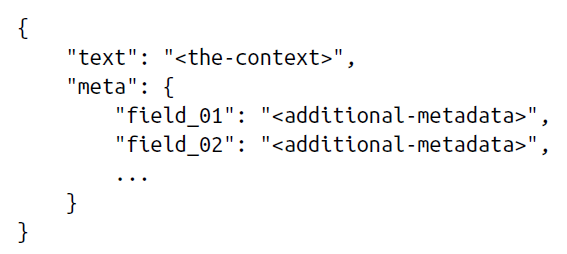

It is not text, it should be content. See [write_documents documentation](https://colab.research.google.com/drive/1UHkxej4EkFz0lhr9FIAomvcaY7T-VtOT#scrollTo=Xr80Z8DQn3Uk&line=4&uniqifier=1) for the correct implementation.

meta can be used for applying filters during retrievals.


We will store the data from [subjqa](https://huggingface.co/datasets/subjqa)

In [9]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.14.1 requires huggingface_hub<0.18,>=0.16.4, but you have huggingface-hub 0.19.4 which is incompatible.


In [1]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name="electronics")

In [2]:
subjqa['train']['answers'][1]

{'text': ['Bass is weak as expected',
  'Bass is weak as expected, even with EQ adjusted up'],
 'answer_start': [1302, 1302],
 'answer_subj_level': [1, 1],
 'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
 'is_ans_subjective': [True, True]}

In [3]:
import pandas as pd

#Flatten the dataset
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

Now we will install elastisearch and load the data ito the document store using haystack pipeline. See [documenatation for implementation](https://haystack.deepset.ai/tutorials/03_scalable_qa_system).

In [4]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab,preprocessing,elasticsearch,inference]


  Using cached huggingface_hub-0.17.3-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.15.0 requires huggingface-hub>=0.18.0, but you have huggingface-hub 0.17.3 which is incompatible.


In [5]:
%%bash

wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
chown -R daemon:daemon elasticsearch-7.9.2

In [6]:
%%bash --bg

sudo -u daemon -- elasticsearch-7.9.2/bin/elasticsearch

In [7]:
import time

time.sleep(30)

In [8]:
#Confirm whether Elasticseach is running
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "763d07daa9dc",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "7SjTisvuSjO0VMnCc9Ah8A",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [9]:
import os
from haystack.document_stores import ElasticsearchDocumentStore

# Get the host where Elasticsearch is running, default to localhost
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [10]:
for split, df in dfs.items():
	# Exclude duplicate reviews
	docs = [{"content": row["context"],
			"meta":{"item_id": row["title"], "question_id": row["id"],
			"split": split}}
		for _,row in df.drop_duplicates(subset="context").iterrows()]
	document_store.write_documents(docs, index="document")
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


ElasticsearchDocumentStore has 2 indices:


1. *document* for storing the documents
2. *[label](https://colab.research.google.com/drive/1UHkxej4EkFz0lhr9FIAomvcaY7T-VtOT#scrollTo=zLuJ_HjYNtx7&line=7&uniqifier=1)* for storing the annotated answer spans

In the above implementation, we have only stored the reviews in the document index.



## Initializing a retriever

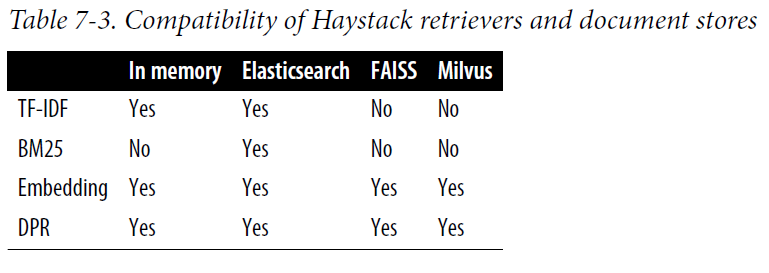

In [11]:
from haystack.nodes import BM25Retriever

es_retriever = BM25Retriever(document_store=document_store)

In [12]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
  query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [13]:
retrieved_docs[0]

<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}>

Note that we ask a question about a particular product. This is why we use meta to filter out documents. The result also gives how relevant this document is by the score field. Checking the score for the next document.

In [14]:
retrieved_docs[1]

<Document: {'content': 'Plays Netflix great, WiFi capability has great range. Resolution on the screen is AMAZING! For the price you cannot go wrong. Bought one for my spouse and myself after becoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones to really hear it all.Battery life is super long and can go 3 or 4 days without a recharge from moderate use.A steal at $199.99.', 'content_type': 'text', 'score': 0.6846554055365114, 'meta': {'item_id': 'B0074BW614', 'question_id': '998d564607f10bf6dbbd20b33b8fbbf1', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '41f4a1710c6f3be65c7814326b662ab6'}>

## Initializing a reader
The reader is used to extract the answers from the retrieved documents.

In [15]:
from haystack.nodes import FARMReader

max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path="deepset/minilm-uncased-squad2", use_gpu=True, max_seq_len=max_seq_length, doc_stride=doc_stride, return_no_answer=True)


Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
question = 'How much music can this hold?'
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  1.64 Batches/s]

{'query': 'How much music can this hold?', 'no_ans_gap': 12.64809501171112, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293065905570984, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}


The above test shows that the reader is able to get the correct answer for the given question and the context.

## Using the haystack pipeline abstraction
The pipeline will take the retriever, reader as input and provides an abstraction over this whole process.

In [17]:
from haystack import Pipeline

querying_pipeline = Pipeline()
querying_pipeline.add_node(component=es_retriever, name="Retriever", inputs=["Query"])
querying_pipeline.add_node(component=reader, name="Reader", inputs=["Retriever"])

n_answers = 3
prediction = querying_pipeline.run(
    query=query, params={"Retriever": {"top_k": 3}, "Reader": {"top_k": n_answers},  "filters": {
            "item_id": [item_id],
            "split":["train"]
        }}
)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 13.13 Batches/s]


In [18]:
from pprint import pprint

pprint(prediction)

{'answers': [<Answer {'answer': 'it is great for reading books when no light is available', 'type': 'extractive', 'score': 0.5443062782287598, 'context': 'ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t', 'offsets_in_document': [{'start': 216, 'end': 272}], 'offsets_in_context': [{'start': 47, 'end': 103}], 'document_ids': ['41f4a1710c6f3be65c7814326b662ab6'], 'meta': {'item_id': 'B0074BW614', 'question_id': '998d564607f10bf6dbbd20b33b8fbbf1', 'split': 'train'}}>,
             <Answer {'answer': 'I mainly use it for book reading', 'type': 'extractive', 'score': 0.469524621963501, 'context': ' is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la', 'offsets_in_document': [{'start': 132, 'end': 164}], 'offsets_in_context': [{'start': 59, 'end': 91}], 'document_ids': ['252e83e25d52df7311d597dc

In [19]:
from haystack.utils import print_answers

print_answers(prediction, details="minimum")  ## Choose from `minimum`, `medium` and `all`


'Query: Is it good for reading?'
'Answers:'
[   {   'answer': 'it is great for reading books when no light is available',
        'context': 'ecoming addicted to hers! Our son LOVES it and it is great '
                   'for reading books when no light is available. Amazing '
                   'sound but I suggest good headphones t'},
    {   'answer': 'I mainly use it for book reading',
        'context': ' is my third one.  I never thought I would want a fire for '
                   'I mainly use it for book reading.  I decided to try the '
                   'fire for when I travel I take my la'},
    {'answer': ''}]


# Improving QA pipeline

## Evaluating the Retriever
The retriever sets the upper bound of the performance of the QA system. Hence it is important to evaluate the retriever. A document is considered correctly retrieved if it contains the gold answer string within it.

### Implementation 1: Steps can be found [here](https://haystack.deepset.ai/tutorials/05_evaluation)

In [20]:
#pd.set_option('display.max_colwidth', None)
dfs["test"].loc[0:5, ["question","context", "answers.text"]]

,question,context,answers.text
0,What is the tonal balance of these headphones?,"I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580. The Sony MDRV6 excells as the best value of any headphone that I've ever owned. They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent. The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic. The pads that come on the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that the thin foam cover is glued to the pad around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the pad and the face of the headphone. This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable. I read on a web forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did this replacement on my one pair that had a damaged pad, the increase in comfort was so great that I immediately did the other pair. The thin cover can be glued down to the headphone face if needed to hold it in place, which then allows the top and rear of your ear to naturally slide under the inner circumference of the pad, which is considerably more comfortable. I can recommend this trivial modification without reservation to anyone who owns these headphones. Even if you don't replace the pads with the BeyerDynamic velour pads, I suggest removing the pads anyway, then carefully separating the thin cover from the pad, and glueing the cover directly to the headphone surface.",[I have been a headphone fanatic for thirty years]
1,How would you describe the texture of the lens at all focal lengths above 150mm?,"UPDATED: 5/20/2011: I used my D700, and only my 50mm F1.8 to capture my Grandson's first haircut! I posted an image here. And, on the way home following the haircut, a clearing storm brought some gorgeous bluish-black clouds at dusk so I swung down towards the river and shot a couple of shots with the 50mm. I posted one here called ""Blue Hour"". Enjoy. Seriously, can't go wrong -- though the price seems to be creeping upwards...This 50mm 1.8 is an excellent purchase at around a hundred bucks. I hate to use the word investment, because we know camera equipment is definitely NOT an investment. I bought it because I heard so much about it, and, I had a 50mm back in my old film days. I have not been disappointed. I will agree with many here who say that at F1.8 the results are less than stellar. This is true--- there is a lack of contrast, not necessarily sharpness (at least in my copy of the lens) that you will notice. Since I know that as a fact going in to a shoot or session, I set my aperture at F2.0, or F2.2 on my D700, or D300. This solves the problem. The resulting images at F 2.0 and above are amazingly sharp, and clear. Don't get me wrong, I love my 16-35F4VR, and my 24-70F2.8 but this 50mm rocks as a standalone lens when the situation demands fast lens. As a matter of fact, in a few hours I'm heading off to my grandsons first haircut of his life. What did I pack? The D700 (for better high ISO performance than the D300), and my 50mm 1.8.For the price (which seems to have risen lately and rightly so) you can't go wrong. Even if you have other zoom lenses that cover this range as I do, this lens is unbelievably useful in low li

In [21]:
from haystack.schema import EvaluationResult, MultiLabel, Label, Document, Answer

'''
Load the test gold-standard to the label index of the document store.
This will be used for the evaluation.
'''

labels = []
for i, row in dfs["test"].iterrows():

	# Metadata used for filtering in the Retriever
	meta = {"item_id": row["title"], "question_id": row["id"]}

	# Populate labels for questions with answers
	if len(row["answers.text"]):
		for answer in row["answers.text"]:
			label = Label(
				query=row["question"],
        answer= Answer(
            answer = answer),
        document = Document(
            id = i,
            content_type="text",
            content = row["context"]
        ),origin = "gold-label",
				meta=meta,
        is_correct_answer=True, is_correct_document=True,no_answer=False)
			labels.append(label)
	else:
		# Populate labels for questions without answers
		label = Label(
		query=row["question"],
    answer = Answer(
      answer = ""),
    document = Document(
            id = i,
            content_type="text",
            content = row["context"]
        ), origin="gold-label",
		meta=meta, is_correct_answer=True, is_correct_document=True,
		no_answer=True)
		labels.append(label)

In [22]:
print(labels[0])

<Label: {'id': '0df16ae3-f97e-4a94-9f5d-1a4a5a01373c', 'query': 'What is the tonal balance of these headphones?', 'document': {'id': '0', 'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic. 

In [23]:
#Write the labels to the label index of the document store
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 910 question-answer pairs


In [24]:
#Get a list of MultLabel objects containing the mapping between the question ID and the corresponding answer
labels_agg = document_store.get_all_labels_aggregated(
  index="label",
  open_domain=True,
  aggregate_by_meta=["item_id"]
)
print(len(labels_agg))
#Will aggregate the question answer pair associated with a unique-id

330


In [25]:
print(labels_agg[109])

<MultiLabel: {'labels': [{'id': '80eeb443-5f63-445e-a8c9-2dc62a812509', 'query': 'How does the fan work?', 'document': {'id': '112', 'content': 'the usb on the back caused my mac to restart when i would plug something into about 50% of the time.  very annoying but the fan is really really good!', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'the fan is really really good', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_ids': None, 'meta': {}}, 'pipeline_id': None, 'created_at': '2023-12-13 13:25:33', 'updated_at': '2023-12-13 13:25:33', 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id': ['B002MU1ZRS']}}, {'id': '63dbd481-f5c2-4e50-8793-2bb6ce5134e4', 'query': 'How does the fan work?', 'document': {'id':

In [26]:
!pip install farm-haystack[metrics]

More details on how to correctly use eval() can be found [here](https://docs.haystack.deepset.ai/docs/evaluation).

In [27]:
#Check the quality of the QA pipeline on the labels_agg
eval_result = querying_pipeline.eval(labels=labels_agg,
                                     params={"Retriever": {"top_k": 3}})

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 31.15 Batches/s]


In [28]:
retriever_result = eval_result["Retriever"]
reader_result = eval_result["Reader"]

In [29]:
# We can filter for all documents retrieved for a given query
query = "What is the tonal balance of these headphones?"
retriever_tone_balance = retriever_result[retriever_result["query"] == query]
retriever_tone_balance

,multilabel_id,query,filters,gold_answers,context,gold_contexts,gold_id_match,context_match,answer_match,gold_id_or_answer_match,...,rank,document_id,gold_document_ids,gold_documents_id_match,gold_contexts_similarity,gold_answers_match,type,node,eval_mode,index
0,1f380c5429a27445d5771686af8b73a3,What is the tonal balance of these headphones?,"b'{""item_id"": [""B00001WRSJ""]}'",[I have been a headphone fanatic for thirty years],"I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580. The Sony MDRV6 excells as the best value of any headphone that I've ever owned. They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent. The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic. The pads that come on the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that the thin foam cover is glued to the pad around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the pad and the face of the headphone. This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable. I read on a web forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did this replacement on my one pair that had a damaged pad, the increase in comfort was so great that I immediately did the other pair. The thin cover can be glued down to the headphone face if needed to hold it in place, which then allows the top and rear of your ear to naturally slide under the inner circumference of the pad, which is considerably more comfortable. I can recommend this trivial modification without reservation to anyone who owns these headphones. Even if you don't replace the pads with the BeyerDynamic velour pads, I suggest removing the pads anyway, then carefully separating the thin cover from the pad, and glueing the cover directly to the headphone surface.","[I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580. The Sony MDRV6 excells as the best value of any headphone that I've ever owned. They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent. The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic. The pads that come on the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that the thin foam cover is glued to the pad around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the pad and the face of the headphone. This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable. I read on a web forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did

In [30]:
reader_tone_balance = reader_result[reader_result["query"] == query]
reader_tone_balance

,multilabel_id,query,filters,gold_answers,answer,context,exact_match,f1,exact_match_context_scope,f1_context_scope,...,offsets_in_context,gold_offsets_in_contexts,gold_answers_exact_match,gold_answers_f1,gold_documents_id_match,gold_contexts_similarity,type,node,eval_mode,index
0,1f380c5429a27445d5771686af8b73a3,What is the tonal balance of these headphones?,"b'{""item_id"": [""B00001WRSJ""]}'",[I have been a headphone fanatic for thirty years],octave-to-octave,"ally good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent. The sound quality is all in all comparable",0.0,0.0,0.0,0.0,...,"[{'start': 67, 'end': 83}]",[],[0],[0],[0.0],[100.0],answer,Reader,integrated,0
1,1f380c5429a27445d5771686af8b73a3,What is the tonal balance of these headphones?,"b'{""item_id"": [""B00001WRSJ""]}'",[I have been a headphone fanatic for thirty years],,None,0.0,0.0,0.0,0.0,...,"[{'start': 0, 'end': 0}]",[],[0],[0],[0.0],[0.0],answer,Reader,integrated,1
2,1f380c5429a27445d5771686af8b73a3,What is the tonal balance of these headphones?,"b'{""item_id"": [""B00001WRSJ""]}'",[I have been a headphone fanatic for thirty years],it's punchier and more...accurate,"oys even more. I think it's the bass that separates them...it's punchier and more...accurate, you know? without being overly done. out of the box they",0.0,0.0,0.0,0.0,...,"[{'start': 59, 'end': 92}]",[],[0],[0],[0.0],[47.0],answer,Reader,integrated,2
3,1f380c5429a27445d5771686af8b73a3,What is the tonal balance of these headphones?,"b'{""item_id"": [""B00001WRSJ""]}'",[I have been a headphone fanatic for thirty years],perfect in every way,"with sound and music. Audiophile? Maybe. These headphones are so perfect in every way. The sound is so crisp, clear and clean, the design is awesome a",0.0,0.0,0.0,0.0,...,"[{'start': 65, 'end': 85}]",[],[0],[0],[0.0],[50.0],answer,Reader,integrated,3
4,1f380c5429a27445d5771686af8b73a3,What is the tonal balance of these headphones?,"b'{""item_id"": [""B00001WRSJ""]}'",[I have been a headphone fanatic for thirty years],comfortable,"open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously",0.0,0.0,0.0,0.0,...,"[{'start': 70, 'end': 81}]",[],[0],[0],[0.0],[100.0],answer,Reader,integrated,4
664,a4b00b3f8ab0997d4164fee87cab56ec,What is the tonal balance of these headphones?,"b'{""item_id"": [""B003LPTAYI""]}'",[],,None,1.0,1.0,1.0,1.0,...,"[{'start': 0, 'end': 0}]",[],[1],[1],[],[],answer,Reader,integrated,0
665,a4b00b3f8ab0997d4164fee87cab56ec,What is the tonal balance of these headphones?,"b'{""item_id"": [""B003LPTAYI""]}'",[],"Everything was crisp, clear, and the headphones are comfortable","better than I expected in a product at this price point. Everything was crisp, clear, and the headphones are comfortable. What else is there to say?",0.0,0.0,0.0,0.0,...,"[{'start': 58, 'end': 121}]",[],[0],[0],[],[],answer,Reader,integrated,1
666,a4b00b3f8ab0997d4164fee87cab56ec,What is the tonal balance of these headphones?,"b'{""item_id"": [""B003LPTAYI""]}'",[],comfort and function,"02's are simply amazing not just for the price point but for the comfort and function. The sound quality is absolutely stellar, even when listening to",0.0,0.0,0.0,0.0,...,"[{'start': 65, 'end': 85}]",[],[0],[0],[],[],answer,Reader,integrated,2
667,a4b00b3f8ab0997d4164fee87cab56ec,What is the tonal balance of these headphones?,"b'{""item_id"": [""B003LPTAYI""]}'",[],They do not have a lot off bass,"ones have incredible sound quality for an incredible price. They do not have a lot off bass, so all of you people looking for tons of bass, you won't",0.0,0.0,0.0,0.0,...,"[{'start': 60, 'end': 91}]",[],[0],[0],[],[],answer,Reader,integrated,3


In [31]:
# Save the evaluation result so that we can reload it later and calculate evaluation metrics without running the pipeline again.
eval_result.save("../")

In [32]:
saved_eval_result = EvaluationResult.load("../")
metrics = saved_eval_result.calculate_metrics()
print(f'Retriever - Recall (single relevant document): {metrics["Retriever"]["recall_single_hit"]}')
print(f'Retriever - Recall (multiple relevant documents): {metrics["Retriever"]["recall_multi_hit"]}')
print(f'Retriever - Mean Reciprocal Rank: {metrics["Retriever"]["mrr"]}')
print(f'Retriever - Precision: {metrics["Retriever"]["precision"]}')
print(f'Retriever - Mean Average Precision: {metrics["Retriever"]["map"]}')


Retriever - Recall (single relevant document): 0.896969696969697
Retriever - Recall (multiple relevant documents): 0.8911616161616162
Retriever - Mean Reciprocal Rank: 0.8368686868686868
Retriever - Precision: 0.7439393939393939
Retriever - Mean Average Precision: 0.8328282828282828


In [33]:
#Can be done like this as well
metrics = eval_result.calculate_metrics()
print(f'Retriever - Recall (single relevant document): {metrics["Retriever"]["recall_single_hit"]}')
print(f'Retriever - Recall (multiple relevant documents): {metrics["Retriever"]["recall_multi_hit"]}')
print(f'Retriever - Mean Reciprocal Rank: {metrics["Retriever"]["mrr"]}')
print(f'Retriever - Precision: {metrics["Retriever"]["precision"]}')
print(f'Retriever - Mean Average Precision: {metrics["Retriever"]["map"]}')


Retriever - Recall (single relevant document): 0.896969696969697
Retriever - Recall (multiple relevant documents): 0.8911616161616162
Retriever - Mean Reciprocal Rank: 0.8368686868686868
Retriever - Precision: 0.7439393939393939
Retriever - Mean Average Precision: 0.8328282828282828


In [34]:
metrics["Retriever"]["recall_single_hit"]

0.896969696969697

Unsure whether the metdata filter is being applied.

### Implementation 2

While the above method is from the haystack documentation, we will now implement the way it has been mentioned in the book.

In the book, a [pipeline](https://docs.haystack.deepset.ai/docs/nodes_overview) is created with the Retriever as the start node which receieves the query as input. This node is connected to an evaluation node. This whole process is encapsulated in a class called EvalRetrieverPipeline. We create an instance of this class and call the *run()* function. We pass the query, label and the filter to evaluate the retriever.

First we create the EvalRetrieverPipeline class:

In [35]:
from haystack import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
	def __init__(self, retriever):
		#Create the retriever
		self.retriever = retriever

		#Create the evaluation component
		self.eval_retriever = EvalDocuments()

		#Create the pipline with the retriever and the evaluator
		pipe = Pipeline()

		#Adding the retriever node to the pipeline. Query is the input
		pipe.add_node(component=self.retriever, name="ESRetriever",
			inputs=["Query"])

		#Adding the evaluator node to the pipeline. The retriever is the input.
		pipe.add_node(component=self.eval_retriever, name="EvalRetriever",
			inputs=["ESRetriever"])

		#Creating teh pipeline object
		self.pipeline = pipe

ModuleNotFoundError: ignored

Implementation 2 doesn't seem to work as there is no module called haystack.eval. The latest code from haystack(Implementation 1) seems to be the only option.

### Finding the best k in retriever

In [36]:
topk_results = {}
topk_values = [1,3,5,10,20]
#topk_values = [1,3]
for topk in topk_values:
	eval_result = querying_pipeline.eval(labels=labels_agg,
                                      params={"Retriever": {"top_k": topk}})
	metrics = eval_result.calculate_metrics()
	topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
topk_results_df = pd.DataFrame.from_dict(topk_results, orient="index")

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 16.29 Batches/s]


<Axes: >

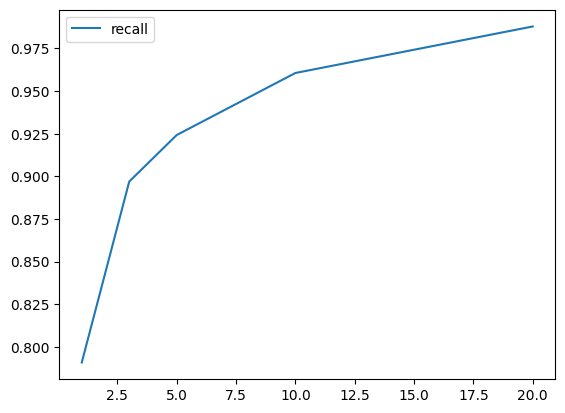

In [37]:
topk_results_df.plot()

In [48]:
topk_results_df

,recall
1,0.790909
3,0.896970
5,0.924242
10,0.960606
20,0.987879


### Dense Passage Retrieval(DPR)

The main drawback of sparse retrievers are that they fail to retrieve those relevant documents which doesn't contain the terms in the query. The solution for this is to use a Dense Passage Retriever.

The main idea is to use 2 encoders:
1. to encode the question
2. to encode the passage

These encoders map the input text to d-dimensional vector representation of [CLS] token.

For this we have to choose encoders which are trained for this specific purpose. The encoders will be given a question and 2 passages: relevant(positive) passage and another irrelevant(negative) passage. This encoder is trained to learn the question and the corresponding relevant passages having the highest simialrity.

More details on what model to choose as the query retriever or passage retriever can be found [here](https://docs.haystack.deepset.ai/docs/retriever#dense-passage-retrieval).

There are 2 steps in using a DPR retriever:
1. Convert the questions and passages in the document store to vector embeddings.
2. Create a pipline using the DPR retriever to get the answer.

Let's start by converting the document store into vector embeddings.

In [42]:
from haystack.nodes import DensePassageRetriever

#Initialize a dpr for the document store we had created
dpr_retriever = DensePassageRetriever(document_store=document_store,
  query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
  passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
embed_title=False)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [43]:
#Apply the embeddings on all the documents in our document store
document_store.update_embeddings(retriever=dpr_retriever)

Create embeddings: 100%|██████████| 1616/1616 [00:22<00:00, 73.45 Docs/s]
Updating embeddings: 10000 Docs [00:45, 221.71 Docs/s]


Next step is to create a pipeline with a retriever using the DPR.

In [45]:
querying_pipeline = Pipeline()
querying_pipeline.add_node(component=dpr_retriever, name="Retriever", inputs=["Query"])
querying_pipeline.add_node(component=reader, name="Reader", inputs=["Retriever"])

n_answers = 3
prediction = querying_pipeline.run(
    query=query, params={"Retriever": {"top_k": 3}, "Reader": {"top_k": n_answers},  "filters": {
            "item_id": [item_id],
            "split":["train"]
        }}
)
pprint(prediction)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 16.45 Batches/s]

{'_debug': {'Reader': {'exec_time_ms': 94.22,
                       'input': {'debug': True,
                                 'documents': [<Document: {'content': "I bought this via my credit union's rewards program, practically the only up to date electronic gizmo offered. I love, love it, love it. I was sans electric for four days during Sandy and I could still read and email. Not only that but getting all comfy under the covers with it is akin to the flashlight `forts' we used to make as kids. It is very easy to figure out, usable right out of the box and then, with apps, highly configurable if you are into that sort of thing which I am. The color is brilliantly crisp and clear and the audio is great although I have only listened to books on it so far, no music. I splurged on the leather cover - horrendously overpriced - and carry it with me in my purse everywhere I go.I do wish it had an app like the iPad one where you hold it up to the sky and see the constellations above you in 

In [49]:
topk_results_dpr = {}
topk_values = [1,3,5,10,20]
#topk_values = [1]
for topk in topk_values:
	eval_result = querying_pipeline.eval(labels=labels_agg,
                                      params={"Retriever": {"top_k": topk}})
	metrics = eval_result.calculate_metrics()
	topk_results_dpr[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
topk_results_dpr_df = pd.DataFrame.from_dict(topk_results_dpr, orient="index")

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 32.18 Batches/s]


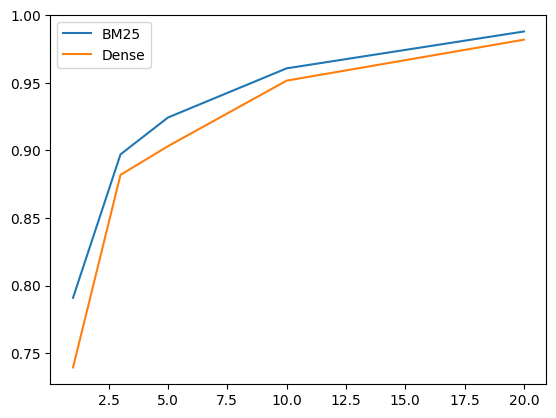

In [55]:
import matplotlib.pyplot as plt

plt.plot(topk_results_df.index, topk_results_df['recall'], label='BM25')
plt.plot(topk_results_dpr_df.index, topk_results_dpr_df['recall'], label='Dense')
plt.legend()

The performance of the DPR retriever can be improved by fine-tuning on the target domain, see implementation [here](https://haystack.deepset.ai/tutorials/09_dpr_training).

Also, the similarity search can be sped up using the FAISS library.

## Evaluating readers


In [56]:
metrics = saved_eval_result.calculate_metrics()
print(f'Reader - F1-Score: {metrics["Reader"]["f1"]}')
print(f'Reader - Exact Match: {metrics["Reader"]["exact_match"]}')

Reader - F1-Score: 0.6870027922482301
Reader - Exact Match: 0.5696969696969697


Exact match is a much stricter metrics. But F1-score can fail to catch truly incorrect answers. Tracking both metrics is a good strategy to balance the trade-off between underestimating (EM) and overestimating
(F1-score) model performance.
Now in general, there are multiple valid. The overall EM and F1 scores for the model are
then obtained by averaging over the individual scores of each question-answer pair.

## Domain adaptation
Transformer models trained on SQUAD overfit to SQUAD data-set. That's why we see a bad EM and F1 score of the SubjQA dataset as seen above. To circumvent this problem, we can make the reader generalize better on unseen data. In other words, we can fine-tune the MiniLM model further on the SubjQA dataset.

For this, we need to convert the SubjQA datset to SQUAD structure.

In [62]:
#pd.reset_option('all')

#From page 201 of the book. When a product is passed, it is converted to
#a passage in the SQUAD structure.
def create_paragraphs(df):
	paragraphs = []
	id2context = dict(zip(df["review_id"], df["context"]))
	for review_id, review in id2context.items():
		qas = []
		# Filter for all question-answer pairs about a specific context
		review_df = df.query(f"review_id == '{review_id}'")
		id2question = dict(zip(review_df["id"], review_df["question"]))
		# Build up the qas array
		for qid, question in id2question.items():
			# Filter for a single question ID
			question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
			ans_start_idxs = question_df["answers.answer_start"][0].tolist()
			ans_text = question_df["answers.text"][0].tolist()
			# Fill answerable questions
			if len(ans_start_idxs):
				answers = [
				{"text": text, "answer_start": answer_start}
				for text, answer_start in zip(ans_text, ans_start_idxs)]
				is_impossible = False
			else:
				answers = []
				is_impossible = True
			# Add question-answer pairs to qas
			qas.append({"question": question, "id": qid,
					"is_impossible": is_impossible, "answers": answers})
			# Add context and question-answer pairs to paragraphs
		paragraphs.append({"qas": qas, "context": review})
	return paragraphs

In [63]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)
#This is an example of a single product in SQUAD structure

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [64]:
#Now convert the entire SubjQA data into the SQUAD structure and store it into a JSON file
import json
def convert_to_squad(dfs):
	for split, df in dfs.items():
		subjqa_data = {}
		# Create `paragraphs` for each product ID
		groups = (df.groupby("title").apply(create_paragraphs)
				.to_frame(name="paragraphs").reset_index())
		subjqa_data["data"] = groups.to_dict(orient="records")
		# Save the result to disk
		with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
			json.dump(subjqa_data, f)
convert_to_squad(dfs)

In [65]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

In [66]:
#Train the reader
reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
	train_filename=train_filename, dev_filename=dev_filename,save_dir="dom_adap_read")

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

In [67]:
#We again create a pipeline with this domain adapted reader
dom_adap_reader = FARMReader(model_name_or_path="dom_adap_read")

querying_pipeline = Pipeline()
querying_pipeline.add_node(component=es_retriever, name="Retriever", inputs=["Query"])
querying_pipeline.add_node(component=dom_adap_reader, name="Reader", inputs=["Retriever"])

#Check the quality of the QA pipeline on the labels_agg
eval_result = querying_pipeline.eval(labels=labels_agg,
                                     params={"Retriever": {"top_k": 3}})

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 37.18 Batches/s]


AttributeError: ignored

In [68]:
dom_metrics = eval_result.calculate_metrics()
print(f'Reader - F1-Score: {dom_metrics["Reader"]["f1"]}')
print(f'Reader - Exact Match: {dom_metrics["Reader"]["exact_match"]}')

Reader - F1-Score: 0.26831119699159844
Reader - Exact Match: 0.15757575757575756


I think the issue is that the question and the passages are converted to vector embeddings. Need to check this.

# Miscellaneous Information

## Saving the environment

In [41]:
from google.colab import files

# Save the requirements.txt file
with open('requirements.txt', 'w') as f:
    !pip freeze > requirements.txt

# Download the file
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>